In [2]:
import pandas as pd
import numpy as np
from numpy import array

import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as s

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error,mean_absolute_error, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import datasets, svm
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LassoCV

import os

In [5]:
# Import the training and testing data sets
file = os.getcwd();

trainfile = file + '/UNSW_NB15_training-set.csv' 
train = pd.read_csv(trainfile)

testfile = file + '/UNSW_NB15_testing-set.csv'
test = pd.read_csv(testfile)

In [6]:
# Combine the training and testing data sets
total = pd.concat([train, test], axis=0)
# Replace the 'Normal' and 'Attack' labels with 0 and 1
total['label'] = total['label'].replace([0,1], ['Normal', 'Attack'])

Attack    164673
Normal     93000
Name: label, dtype: int64


<AxesSubplot:ylabel='label'>

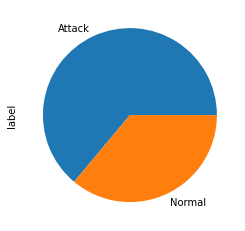

In [7]:
# Print the stats for the combined data sets, print a pie chart
print(total['label'].value_counts())
total['label'].value_counts().plot(kind='pie')

In [8]:
# Get summary stats for the features in the combined data set
total.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
count,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,257673.000000,257673.000000,2.576730e+05,...,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000
mean,72811.823858,1.246715,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,180.000931,84.754957,7.060869e+07,...,6.050467,5.238271,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274
std,48929.917641,5.974305,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,102.488268,112.762131,1.857313e+08,...,8.173749,8.160822,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,32210.000000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,62.000000,0.000000,1.231800e+04,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000
50%,64419.000000,0.004285,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,254.000000,29.000000,7.439423e+05,...,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000
75%,110923.000000,0.685777,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,254.000000,252.000000,8.000000e+07,...,6.000000,4.000000,3.000000,8.000000,0.000000,0.000000,0.000000,8.000000,11.000000,0.000000
max,175341.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,...,59.000000,59.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000


In [9]:
# Encoding for non-numerical data
service_ = LabelEncoder()
proto_ = LabelEncoder()
state_ = LabelEncoder()

test['service_le'] = service_.fit_transform(test.service)
test['proto_le'] = proto_.fit_transform(test.proto)
test['state_le'] = state_.fit_transform(test.state)

train['service_le'] = service_.fit_transform(train.service)
train['proto_le'] = proto_.fit_transform(train.proto)
train['state_le'] = state_.fit_transform(train.state)

_service = OneHotEncoder()
_proto = OneHotEncoder()
_state = OneHotEncoder()

service = _service.fit_transform(test.service_le.values.reshape(-1,1)).toarray()
proto = _proto.fit_transform(test.proto_le.values.reshape(-1,1)).toarray()
state = _state.fit_transform(test.state_le.values.reshape(-1,1)).toarray()

oh = pd.DataFrame(service, columns = ["service_"+str(int(i)) for i in range(service.shape[1])])
test = pd.concat([test, oh], axis=1)

oh = pd.DataFrame(proto, columns = ["proto_"+str(int(i)) for i in range(proto.shape[1])])
test = pd.concat([test, oh], axis=1)

oh = pd.DataFrame(state, columns = ["state_"+str(int(i)) for i in range(state.shape[1])])
test = pd.concat([test, oh], axis=1)

service = _service.fit_transform(train.service_le.values.reshape(-1,1)).toarray()
proto = _proto.fit_transform(train.proto_le.values.reshape(-1,1)).toarray()
state = _state.fit_transform(train.state_le.values.reshape(-1,1)).toarray()

oh = pd.DataFrame(service, columns = ["service_"+str(int(i)) for i in range(service.shape[1])])
train = pd.concat([train, oh], axis=1)

oh = pd.DataFrame(proto, columns = ["proto_"+str(int(i)) for i in range(proto.shape[1])])
train = pd.concat([train, oh], axis=1)

oh = pd.DataFrame(state, columns = ["state_"+str(int(i)) for i in range(state.shape[1])])
train = pd.concat([train, oh], axis=1)

In [10]:
test.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,proto_128,proto_129,proto_130,state_0,state_1,state_2,state_3,state_4,state_5,state_6
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
# Remove categorical data

test.drop(columns=['proto','service','state'], inplace = True )
test.shape

train.drop(columns=['proto','service','state'], inplace = True )
train.shape

train.drop(columns='attack_cat', inplace = True )
test.drop(columns='attack_cat', inplace = True )

In [12]:
# Normalize data

trained = pd.DataFrame(MinMaxScaler().fit_transform(train), columns = list(train.columns))

tested = pd.DataFrame(MinMaxScaler().fit_transform(test), columns = list(test.columns))


ytest = tested['label']
ytrain = trained['label']

xtrain = trained
xtest = tested

xtest.drop(columns='label', inplace = True)
xtrain.drop(columns='label', inplace = True)

xtrain.drop(columns=['id'], inplace = True)
xtest.drop(columns=['id'], inplace = True)

In [13]:
# Select features with the best scores using mutual_info_classif 
best = SelectKBest(score_func = mutual_info_classif, k = 'all')

i = tested.iloc[:,0:198]
fit = best.fit(xtrain,ytrain)

scores = pd.DataFrame(fit.scores_)
cols = pd.DataFrame(i.columns)

score = pd.concat([cols,scores],axis=1)
score.columns = ['feature','score']

k = score['feature']

t5 = score.nlargest(5,'score')
t10 = score.nlargest(10,'score')
t20 = score.nlargest(20,'score')
t50 = score.nlargest(50,'score')
t100 = score.nlargest(100,'score')

l5 = list(t5['feature'])
l5 = [x for x in l5 if str(x) != 'nan']

l10 = list(t10['feature'])
l10 = [x for x in l10 if str(x) != 'nan']

l20 = list(t20['feature'])
l20 = [x for x in l20 if str(x) != 'nan']

l50 = list(t50['feature'])
l50 = [x for x in l50 if str(x) != 'nan']

l100 = list(t100['feature'])
l100 = [x for x in l100 if str(x) != 'nan']

In [14]:
# Select Top features

xtest5 = tested[l5]
xtrain5 = trained[l5]

xtest10 = tested[l10]
xtrain10 = trained[l10]

xtest20 = tested[l20]
xtrain20 = trained[l20]

xtest50 = tested[l50]
xtrain50 = trained[l50]

xtest100 = tested[l100]
xtrain100 = trained[l100]

In [15]:
# Random Forest Classifier with 5 estimators/features used in the model, 5 best features
tm = -time.time()

rfc5_5 = RandomForestClassifier(n_estimators = 5)
rfc5_5.fit(xtrain5, ytrain)
pred_rfc5_5 = rfc5_5.predict(xtest5)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc5_5.predict(xtrain5)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc5_5))

print(classification_report(ytest, pred_rfc5_5))

print(confusion_matrix(ytest, pred_rfc5_5))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9736171232056393
Test Accuracy  ::  0.8044259826070058
              precision    recall  f1-score   support

         0.0       0.89      0.64      0.75     37000
         1.0       0.76      0.93      0.84     45332

    accuracy                           0.80     82332
   macro avg       0.83      0.79      0.79     82332
weighted avg       0.82      0.80      0.80     82332

[[23863 13137]
 [ 2965 42367]]
Time ::  0.999380350112915


In [16]:
# Random Forest Classifier with 5 estimators/features used in the model, 10 best features
tm = -time.time()

rfc5_10 = RandomForestClassifier(n_estimators = 5)
rfc5_10.fit(xtrain10, ytrain)
pred_rfc5_10 = rfc5_10.predict(xtest10)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc5_10.predict(xtrain10)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc5_10))

print(classification_report(ytest, pred_rfc5_10))

print(confusion_matrix(ytest, pred_rfc5_10))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9743756451714088
Test Accuracy  ::  0.8189160958072196
              precision    recall  f1-score   support

         0.0       0.95      0.63      0.76     37000
         1.0       0.76      0.98      0.86     45332

    accuracy                           0.82     82332
   macro avg       0.86      0.80      0.81     82332
weighted avg       0.85      0.82      0.81     82332

[[23185 13815]
 [ 1094 44238]]
Time ::  1.2458395957946777


In [17]:
# Random Forest Classifier with 5 estimators/features used in the model, 20 best features
tm = -time.time()

rfc5_20 = RandomForestClassifier(n_estimators = 5)
rfc5_20.fit(xtrain20, ytrain)
pred_rfc5_20 = rfc5_20.predict(xtest20)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc5_20.predict(xtrain20)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc5_20))

print(classification_report(ytest, pred_rfc5_20))

print(confusion_matrix(ytest, pred_rfc5_20))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9808088239487627
Test Accuracy  ::  0.8166448039644366
              precision    recall  f1-score   support

         0.0       0.95      0.63      0.75     37000
         1.0       0.76      0.97      0.85     45332

    accuracy                           0.82     82332
   macro avg       0.85      0.80      0.80     82332
weighted avg       0.84      0.82      0.81     82332

[[23193 13807]
 [ 1289 44043]]
Time ::  1.7518622875213623


In [18]:
# Random Forest Classifier with 5 estimators/features used in the model, 50 best features
tm = -time.time()

rfc5_50 = RandomForestClassifier(n_estimators = 5)
rfc5_50.fit(xtrain50, ytrain)
pred_rfc5_50 = rfc5_50.predict(xtest50)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc5_50.predict(xtrain50)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc5_50))

print(classification_report(ytest, pred_rfc5_50))

print(confusion_matrix(ytest, pred_rfc5_50))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9923862644789296
Test Accuracy  ::  0.8323980955157169
              precision    recall  f1-score   support

         0.0       0.97      0.65      0.78     37000
         1.0       0.77      0.98      0.87     45332

    accuracy                           0.83     82332
   macro avg       0.87      0.82      0.82     82332
weighted avg       0.86      0.83      0.83     82332

[[23968 13032]
 [  767 44565]]
Time ::  1.8126075267791748


In [19]:
# Random Forest Classifier with 5 estimators/features used in the model, 100 best features
tm = -time.time()

rfc5_100 = RandomForestClassifier(n_estimators = 5)
rfc5_100.fit(xtrain100, ytrain)
pred_rfc5_100 = rfc5_100.predict(xtest100)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc5_100.predict(xtrain100)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc5_100))

print(classification_report(ytest, pred_rfc5_100))

print(confusion_matrix(ytest, pred_rfc5_100))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9906182809496923
Test Accuracy  ::  0.8428800466404314
              precision    recall  f1-score   support

         0.0       0.96      0.68      0.79     37000
         1.0       0.79      0.98      0.87     45332

    accuracy                           0.84     82332
   macro avg       0.88      0.83      0.83     82332
weighted avg       0.87      0.84      0.84     82332

[[25003 11997]
 [  939 44393]]
Time ::  1.9549529552459717


In [20]:
# Random Forest Classifier with 25 estimators/features used in the model, 5 best features
tm = -time.time()

rfc25_5 = RandomForestClassifier(n_estimators = 25)
rfc25_5.fit(xtrain5, ytrain)
pred_rfc25_5 = rfc25_5.predict(xtest5)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc25_5.predict(xtrain5)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc25_5))

print(classification_report(ytest, pred_rfc25_5))

print(confusion_matrix(ytest, pred_rfc25_5))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9783336470078304
Test Accuracy  ::  0.8073410095710052
              precision    recall  f1-score   support

         0.0       0.90      0.64      0.75     37000
         1.0       0.76      0.94      0.84     45332

    accuracy                           0.81     82332
   macro avg       0.83      0.79      0.80     82332
weighted avg       0.83      0.81      0.80     82332

[[23638 13362]
 [ 2500 42832]]
Time ::  4.135732173919678


In [21]:
# Random Forest Classifier with 25 estimators/features used in the model, 10 best features
tm = -time.time()

rfc25_10 = RandomForestClassifier(n_estimators = 25)
rfc25_10.fit(xtrain10, ytrain)
pred_rfc25_10 = rfc25_10.predict(xtest10)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc25_10.predict(xtrain10)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc25_10))

print(classification_report(ytest, pred_rfc25_10))

print(confusion_matrix(ytest, pred_rfc25_10))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9791377943549997
Test Accuracy  ::  0.8075717825389885
              precision    recall  f1-score   support

         0.0       0.98      0.58      0.73     37000
         1.0       0.74      0.99      0.85     45332

    accuracy                           0.81     82332
   macro avg       0.86      0.79      0.79     82332
weighted avg       0.85      0.81      0.80     82332

[[21527 15473]
 [  370 44962]]
Time ::  4.887283086776733


In [22]:
# Random Forest Classifier with 25 estimators/features used in the model, 20 best features
tm = -time.time()

rfc25_20 = RandomForestClassifier(n_estimators = 25)
rfc25_20.fit(xtrain20, ytrain)
pred_rfc25_20 = rfc25_20.predict(xtest20)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc25_20.predict(xtrain20)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc25_20))

print(classification_report(ytest, pred_rfc25_20))

print(confusion_matrix(ytest, pred_rfc25_20))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9862895728893983
Test Accuracy  ::  0.8205922363115192
              precision    recall  f1-score   support

         0.0       0.98      0.61      0.75     37000
         1.0       0.76      0.99      0.86     45332

    accuracy                           0.82     82332
   macro avg       0.87      0.80      0.81     82332
weighted avg       0.86      0.82      0.81     82332

[[22713 14287]
 [  484 44848]]
Time ::  7.508655786514282


In [23]:
# Random Forest Classifier with 25 estimators/features used in the model, 50 best features
tm = -time.time()

rfc25_50 = RandomForestClassifier(n_estimators = 25)
rfc25_50.fit(xtrain50, ytrain)
pred_rfc25_50 = rfc25_50.predict(xtest50)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc25_50.predict(xtrain50)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc25_50))

print(classification_report(ytest, pred_rfc25_50))

print(confusion_matrix(ytest, pred_rfc25_50))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9974221659509185
Test Accuracy  ::  0.8333697711703834
              precision    recall  f1-score   support

         0.0       0.98      0.64      0.78     37000
         1.0       0.77      0.99      0.87     45332

    accuracy                           0.83     82332
   macro avg       0.88      0.82      0.82     82332
weighted avg       0.87      0.83      0.83     82332

[[23713 13287]
 [  432 44900]]
Time ::  8.684804677963257


In [24]:
# Random Forest Classifier with 25 estimators/features used in the model, 100 best features
tm = -time.time()

rfc25_100 = RandomForestClassifier(n_estimators = 25)
rfc25_100.fit(xtrain100, ytrain)
pred_rfc25_100 = rfc25_100.predict(xtest100)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc25_100.predict(xtrain100)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc25_100))

print(classification_report(ytest, pred_rfc25_100))

print(confusion_matrix(ytest, pred_rfc25_100))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9963100472793015
Test Accuracy  ::  0.8274061118398679
              precision    recall  f1-score   support

         0.0       0.98      0.63      0.77     37000
         1.0       0.76      0.99      0.86     45332

    accuracy                           0.83     82332
   macro avg       0.87      0.81      0.81     82332
weighted avg       0.86      0.83      0.82     82332

[[23181 13819]
 [  391 44941]]
Time ::  9.109999656677246


In [25]:
# Random Forest Classifier with 50 estimators/features used in the model, 5 best features
tm = -time.time()

rfc50_5 = RandomForestClassifier(n_estimators = 50)
rfc50_5.fit(xtrain5, ytrain)
pred_rfc50_5 = rfc50_5.predict(xtest5)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc50_5.predict(xtrain5)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc50_5))

print(classification_report(ytest, pred_rfc50_5))

print(confusion_matrix(ytest, pred_rfc50_5))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9791434975276746
Test Accuracy  ::  0.8063328960792887
              precision    recall  f1-score   support

         0.0       0.90      0.64      0.75     37000
         1.0       0.76      0.94      0.84     45332

    accuracy                           0.81     82332
   macro avg       0.83      0.79      0.80     82332
weighted avg       0.82      0.81      0.80     82332

[[23717 13283]
 [ 2662 42670]]
Time ::  8.267976999282837


In [26]:
# Random Forest Classifier with 50 estimators/features used in the model, 10 best features
tm = -time.time()

rfc50_10 = RandomForestClassifier(n_estimators = 50)
rfc50_10.fit(xtrain10, ytrain)
pred_rfc50_10 = rfc50_10.predict(xtest10)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc50_10.predict(xtrain10)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc50_10))

print(classification_report(ytest, pred_rfc50_10))

print(confusion_matrix(ytest, pred_rfc50_10))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.980917184229587
Test Accuracy  ::  0.8088835446727882
              precision    recall  f1-score   support

         0.0       0.98      0.58      0.73     37000
         1.0       0.75      0.99      0.85     45332

    accuracy                           0.81     82332
   macro avg       0.86      0.79      0.79     82332
weighted avg       0.85      0.81      0.80     82332

[[21600 15400]
 [  335 44997]]
Time ::  9.876421928405762


In [27]:
# Random Forest Classifier with 50 estimators/features used in the model, 20 best features
tm = -time.time()

rfc50_20 = RandomForestClassifier(n_estimators = 50)
rfc50_20.fit(xtrain20, ytrain)
pred_rfc50_20 = rfc50_20.predict(xtest20)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc50_20.predict(xtrain20)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc50_20))

print(classification_report(ytest, pred_rfc50_20))

print(confusion_matrix(ytest, pred_rfc50_20))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9865861378684962
Test Accuracy  ::  0.815150852645387
              precision    recall  f1-score   support

         0.0       0.99      0.60      0.74     37000
         1.0       0.75      0.99      0.86     45332

    accuracy                           0.82     82332
   macro avg       0.87      0.79      0.80     82332
weighted avg       0.86      0.82      0.81     82332

[[22035 14965]
 [  254 45078]]
Time ::  15.25287938117981


In [28]:
# Random Forest Classifier with 50 estimators/features used in the model, 50 best features
tm = -time.time()

rfc50_50 = RandomForestClassifier(n_estimators = 50)
rfc50_50.fit(xtrain50, ytrain)
pred_rfc50_50 = rfc50_50.predict(xtest50)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc50_50.predict(xtrain50)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc50_50))

print(classification_report(ytest, pred_rfc50_50))

print(confusion_matrix(ytest, pred_rfc50_50))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9975989643038422
Test Accuracy  ::  0.8338920468347666
              precision    recall  f1-score   support

         0.0       0.99      0.64      0.78     37000
         1.0       0.77      0.99      0.87     45332

    accuracy                           0.83     82332
   macro avg       0.88      0.82      0.82     82332
weighted avg       0.87      0.83      0.83     82332

[[23659 13341]
 [  335 44997]]
Time ::  17.547386407852173


In [29]:
# Random Forest Classifier with 50 estimators/features used in the model, 100 best features
tm = -time.time()

rfc50_100 = RandomForestClassifier(n_estimators = 50)
rfc50_100.fit(xtrain100, ytrain)
pred_rfc50_100 = rfc50_100.predict(xtest100)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc50_100.predict(xtrain100)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc50_100))

print(classification_report(ytest, pred_rfc50_100))

print(confusion_matrix(ytest, pred_rfc50_100))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9970001311729715
Test Accuracy  ::  0.8297138415197007
              precision    recall  f1-score   support

         0.0       0.99      0.63      0.77     37000
         1.0       0.77      0.99      0.87     45332

    accuracy                           0.83     82332
   macro avg       0.88      0.81      0.82     82332
weighted avg       0.87      0.83      0.82     82332

[[23278 13722]
 [  298 45034]]
Time ::  16.060949087142944


In [30]:
# Random Forest Classifier with 100 estimators/features used in the model, 5 best features
tm = -time.time()

rfc100_5 = RandomForestClassifier(n_estimators = 100)
rfc100_5.fit(xtrain5, ytrain)
pred_rfc100_5 = rfc100_5.predict(xtest5)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc100_5.predict(xtrain5)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc100_5))

print(classification_report(ytest, pred_rfc100_5))

print(confusion_matrix(ytest, pred_rfc100_5))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9793145927079234
Test Accuracy  ::  0.8179322742068698
              precision    recall  f1-score   support

         0.0       0.92      0.65      0.76     37000
         1.0       0.77      0.96      0.85     45332

    accuracy                           0.82     82332
   macro avg       0.85      0.80      0.81     82332
weighted avg       0.84      0.82      0.81     82332

[[23958 13042]
 [ 1948 43384]]
Time ::  16.293118000030518


In [31]:
# Random Forest Classifier with 100 estimators/features used in the model, 10 best features
tm = -time.time()

rfc100_10 = RandomForestClassifier(n_estimators = 100)
rfc100_10.fit(xtrain10, ytrain)
pred_rfc100_10 = rfc100_10.predict(xtest10)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc100_10.predict(xtrain10)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc100_10))

print(classification_report(ytest, pred_rfc100_10))

print(confusion_matrix(ytest, pred_rfc100_10))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.980911481056912
Test Accuracy  ::  0.8063693339163387
              precision    recall  f1-score   support

         0.0       0.99      0.58      0.73     37000
         1.0       0.74      0.99      0.85     45332

    accuracy                           0.81     82332
   macro avg       0.87      0.79      0.79     82332
weighted avg       0.85      0.81      0.79     82332

[[21305 15695]
 [  247 45085]]
Time ::  20.550424098968506


In [32]:
# Random Forest Classifier with 100 estimators/features used in the model, 20 best features
tm = -time.time()

rfc100_20 = RandomForestClassifier(n_estimators = 100)
rfc100_20.fit(xtrain20, ytrain)
pred_rfc100_20 = rfc100_20.predict(xtest20)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc100_20.predict(xtrain20)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc100_20))

print(classification_report(ytest, pred_rfc100_20))

print(confusion_matrix(ytest, pred_rfc100_20))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.987036688509818
Test Accuracy  ::  0.8138633824029539
              precision    recall  f1-score   support

         0.0       0.99      0.59      0.74     37000
         1.0       0.75      1.00      0.85     45332

    accuracy                           0.81     82332
   macro avg       0.87      0.79      0.80     82332
weighted avg       0.86      0.81      0.80     82332

[[21877 15123]
 [  202 45130]]
Time ::  31.664016008377075


In [33]:
# Random Forest Classifier with 100 estimators/features used in the model, 50 best features
tm = -time.time()

rfc100_50 = RandomForestClassifier(n_estimators = 100)
rfc100_50.fit(xtrain50, ytrain)
pred_rfc100_50 = rfc100_50.predict(xtest50)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc100_50.predict(xtrain50)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc100_50))

print(classification_report(ytest, pred_rfc100_50))

print(confusion_matrix(ytest, pred_rfc100_50))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9977187309300164
Test Accuracy  ::  0.828329203711801
              precision    recall  f1-score   support

         0.0       0.99      0.62      0.77     37000
         1.0       0.76      1.00      0.86     45332

    accuracy                           0.83     82332
   macro avg       0.88      0.81      0.82     82332
weighted avg       0.87      0.83      0.82     82332

[[23079 13921]
 [  213 45119]]
Time ::  32.46507716178894


In [34]:
# Random Forest Classifier with 100 estimators/features used in the model, 100 best features
tm = -time.time()

rfc100_100 = RandomForestClassifier(n_estimators = 50)
rfc100_100.fit(xtrain100, ytrain)
pred_rfc100_100 = rfc100_100.predict(xtest100)

print ("Train Accuracy :: ", accuracy_score(ytrain, rfc100_100.predict(xtrain100)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_rfc100_100))

print(classification_report(ytest, pred_rfc100_100))

print(confusion_matrix(ytest, pred_rfc100_100))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9967663010932982
Test Accuracy  ::  0.8266652091531846
              precision    recall  f1-score   support

         0.0       0.99      0.62      0.76     37000
         1.0       0.76      1.00      0.86     45332

    accuracy                           0.83     82332
   macro avg       0.88      0.81      0.81     82332
weighted avg       0.86      0.83      0.82     82332

[[22950 14050]
 [  221 45111]]
Time ::  15.509146928787231


In [35]:
# Ada Boost Classifier with 5 estimators used in the model, 5 best features
tm = -time.time()

abc5_5 = AdaBoostClassifier(n_estimators = 5)
abc5_5.fit(xtrain5, ytrain)
pred_abc5_5 = abc5_5.predict(xtest5)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc5_5.predict(xtrain5)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc5_5))

print(classification_report(ytest, pred_abc5_5))

print(confusion_matrix(ytest, pred_abc5_5))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9206289458825945
Test Accuracy  ::  0.7663241509983967
              precision    recall  f1-score   support

         0.0       1.00      0.48      0.65     37000
         1.0       0.70      1.00      0.82     45332

    accuracy                           0.77     82332
   macro avg       0.85      0.74      0.74     82332
weighted avg       0.83      0.77      0.75     82332

[[17822 19178]
 [   61 45271]]
Time ::  0.9309992790222168


In [36]:
# Ada Boost Classifier with 5 estimators used in the model, 10 best features
tm = -time.time()

abc5_10 = AdaBoostClassifier(n_estimators = 5)
abc5_10.fit(xtrain10, ytrain)
pred_abc5_10 = abc5_10.predict(xtest10)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc5_10.predict(xtrain10)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc5_10))

print(classification_report(ytest, pred_abc5_10))

print(confusion_matrix(ytest, pred_abc5_10))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9130209135341991
Test Accuracy  ::  0.7655589564203469
              precision    recall  f1-score   support

         0.0       0.96      0.50      0.66     37000
         1.0       0.71      0.98      0.82     45332

    accuracy                           0.77     82332
   macro avg       0.83      0.74      0.74     82332
weighted avg       0.82      0.77      0.75     82332

[[18393 18607]
 [  695 44637]]
Time ::  1.1785995960235596


In [37]:
# Ada Boost Classifier with 5 estimators used in the model, 20 best features
tm = -time.time()

abc5_20 = AdaBoostClassifier(n_estimators = 5)
abc5_20.fit(xtrain20, ytrain)
pred_abc5_20 = abc5_20.predict(xtest20)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc5_20.predict(xtrain20)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc5_20))

print(classification_report(ytest, pred_abc5_20))

print(confusion_matrix(ytest, pred_abc5_20))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9130209135341991
Test Accuracy  ::  0.7655589564203469
              precision    recall  f1-score   support

         0.0       0.96      0.50      0.66     37000
         1.0       0.71      0.98      0.82     45332

    accuracy                           0.77     82332
   macro avg       0.83      0.74      0.74     82332
weighted avg       0.82      0.77      0.75     82332

[[18393 18607]
 [  695 44637]]
Time ::  1.8846850395202637


In [38]:
# Ada Boost Classifier with 5 estimators used in the model, 50 best features
tm = -time.time()

abc5_50 = AdaBoostClassifier(n_estimators = 5)
abc5_50.fit(xtrain50, ytrain)
pred_abc5_50 = abc5_50.predict(xtest50)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc5_50.predict(xtrain50)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc5_50))

print(classification_report(ytest, pred_abc5_50))

print(confusion_matrix(ytest, pred_abc5_50))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9226022436281304
Test Accuracy  ::  0.7682917941990963
              precision    recall  f1-score   support

         0.0       0.98      0.50      0.66     37000
         1.0       0.71      0.99      0.82     45332

    accuracy                           0.77     82332
   macro avg       0.84      0.74      0.74     82332
weighted avg       0.83      0.77      0.75     82332

[[18332 18668]
 [  409 44923]]
Time ::  2.6420600414276123


In [39]:
# Ada Boost Classifier with 5 estimators used in the model, 100 best features
tm = -time.time()

abc5_100 = AdaBoostClassifier(n_estimators = 5)
abc5_100.fit(xtrain100, ytrain)
pred_abc5_100 = abc5_100.predict(xtest100)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc5_100.predict(xtrain100)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc5_100))

print(classification_report(ytest, pred_abc5_100))

print(confusion_matrix(ytest, pred_abc5_100))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9226022436281304
Test Accuracy  ::  0.7682917941990963
              precision    recall  f1-score   support

         0.0       0.98      0.50      0.66     37000
         1.0       0.71      0.99      0.82     45332

    accuracy                           0.77     82332
   macro avg       0.84      0.74      0.74     82332
weighted avg       0.83      0.77      0.75     82332

[[18332 18668]
 [  409 44923]]
Time ::  3.332158088684082


In [40]:
# Ada Boost Classifier with 25 estimators used in the model, 5 best features
tm = -time.time()

abc25_5 = AdaBoostClassifier(n_estimators = 25)
abc25_5.fit(xtrain5, ytrain)
pred_abc25_5 = abc25_5.predict(xtest5)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc25_5.predict(xtrain5)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc25_5))

print(classification_report(ytest, pred_abc25_5))

print(confusion_matrix(ytest, pred_abc25_5))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9239653018974455
Test Accuracy  ::  0.7864621289413594
              precision    recall  f1-score   support

         0.0       0.99      0.53      0.69     37000
         1.0       0.72      1.00      0.84     45332

    accuracy                           0.79     82332
   macro avg       0.86      0.76      0.76     82332
weighted avg       0.84      0.79      0.77     82332

[[19599 17401]
 [  180 45152]]
Time ::  3.3430256843566895


In [41]:
# Ada Boost Classifier with 25 estimators used in the model, 10 best features
tm = -time.time()

abc25_10 = AdaBoostClassifier(n_estimators = 25)
abc25_10.fit(xtrain10, ytrain)
pred_abc25_10 = abc25_10.predict(xtest10)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc25_10.predict(xtrain10)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc25_10))

print(classification_report(ytest, pred_abc25_10))

print(confusion_matrix(ytest, pred_abc25_10))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.929200814413058
Test Accuracy  ::  0.8031020745275227
              precision    recall  f1-score   support

         0.0       0.99      0.57      0.72     37000
         1.0       0.74      1.00      0.85     45332

    accuracy                           0.80     82332
   macro avg       0.87      0.78      0.78     82332
weighted avg       0.85      0.80      0.79     82332

[[20951 16049]
 [  162 45170]]
Time ::  4.756060361862183


In [42]:
# Ada Boost Classifier with 25 estimators used in the model, 20 best features
tm = -time.time()

abc25_20 = AdaBoostClassifier(n_estimators = 25)
abc25_20.fit(xtrain20, ytrain)
pred_abc25_20 = abc25_20.predict(xtest20)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc25_20.predict(xtrain20)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc25_20))

print(classification_report(ytest, pred_abc25_20))

print(confusion_matrix(ytest, pred_abc25_20))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9313566136841925
Test Accuracy  ::  0.8061871447310888
              precision    recall  f1-score   support

         0.0       0.99      0.57      0.73     37000
         1.0       0.74      1.00      0.85     45332

    accuracy                           0.81     82332
   macro avg       0.87      0.78      0.79     82332
weighted avg       0.85      0.81      0.79     82332

[[21183 15817]
 [  140 45192]]
Time ::  7.840121269226074


In [43]:
# Ada Boost Classifier with 25 estimators used in the model, 50 best features
tm = -time.time()

abc25_50 = AdaBoostClassifier(n_estimators = 25)
abc25_50.fit(xtrain50, ytrain)
pred_abc25_50 = abc25_50.predict(xtest50)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc25_50.predict(xtrain50)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc25_50))

print(classification_report(ytest, pred_abc25_50))

print(confusion_matrix(ytest, pred_abc25_50))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9362898580480321
Test Accuracy  ::  0.811555652723121
              precision    recall  f1-score   support

         0.0       0.98      0.59      0.74     37000
         1.0       0.75      0.99      0.85     45332

    accuracy                           0.81     82332
   macro avg       0.87      0.79      0.80     82332
weighted avg       0.85      0.81      0.80     82332

[[21883 15117]
 [  398 44934]]
Time ::  12.23608922958374


In [44]:
# Ada Boost Classifier with 25 estimators used in the model, 100 best features
tm = -time.time()

abc25_100 = AdaBoostClassifier(n_estimators = 25)
abc25_100.fit(xtrain100, ytrain)
pred_abc25_100 = abc25_100.predict(xtest100)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc25_100.predict(xtrain100)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc25_100))

print(classification_report(ytest, pred_abc25_100))

print(confusion_matrix(ytest, pred_abc25_100))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9362898580480321
Test Accuracy  ::  0.811555652723121
              precision    recall  f1-score   support

         0.0       0.98      0.59      0.74     37000
         1.0       0.75      0.99      0.85     45332

    accuracy                           0.81     82332
   macro avg       0.87      0.79      0.80     82332
weighted avg       0.85      0.81      0.80     82332

[[21883 15117]
 [  398 44934]]
Time ::  15.51949954032898


In [45]:
# Ada Boost Classifier with 50 estimators used in the model, 5 best features
tm = -time.time()

abc50_5 = AdaBoostClassifier(n_estimators = 50)
abc50_5.fit(xtrain5, ytrain)
pred_abc50_5 = abc50_5.predict(xtest5)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc50_5.predict(xtrain5)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc50_5))

print(classification_report(ytest, pred_abc50_5))

print(confusion_matrix(ytest, pred_abc50_5))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9311684089859189
Test Accuracy  ::  0.7801462371860273
              precision    recall  f1-score   support

         0.0       0.99      0.51      0.68     37000
         1.0       0.72      1.00      0.83     45332

    accuracy                           0.78     82332
   macro avg       0.86      0.76      0.76     82332
weighted avg       0.84      0.78      0.76     82332

[[18996 18004]
 [   97 45235]]
Time ::  6.9728076457977295


In [46]:
# Ada Boost Classifier with 50 estimators used in the model, 10 best features
tm = -time.time()

abc50_10 = AdaBoostClassifier(n_estimators = 50)
abc50_10.fit(xtrain10, ytrain)
pred_abc50_10 = abc50_10.predict(xtest10)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc50_10.predict(xtrain10)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc50_10))

print(classification_report(ytest, pred_abc50_10))

print(confusion_matrix(ytest, pred_abc50_10))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9326284211907084
Test Accuracy  ::  0.8049968420541224
              precision    recall  f1-score   support

         0.0       1.00      0.57      0.72     37000
         1.0       0.74      1.00      0.85     45332

    accuracy                           0.80     82332
   macro avg       0.87      0.78      0.79     82332
weighted avg       0.85      0.80      0.79     82332

[[21049 15951]
 [  104 45228]]
Time ::  9.239381313323975


In [47]:
# Ada Boost Classifier with 50 estimators used in the model, 20 best features
tm = -time.time()

abc50_20 = AdaBoostClassifier(n_estimators = 50)
abc50_20.fit(xtrain20, ytrain)
pred_abc50_20 = abc50_20.predict(xtest20)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc50_20.predict(xtrain20)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc50_20))

print(classification_report(ytest, pred_abc50_20))

print(confusion_matrix(ytest, pred_abc50_20))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9349667219874416
Test Accuracy  ::  0.8065272312102221
              precision    recall  f1-score   support

         0.0       1.00      0.57      0.73     37000
         1.0       0.74      1.00      0.85     45332

    accuracy                           0.81     82332
   macro avg       0.87      0.79      0.79     82332
weighted avg       0.86      0.81      0.79     82332

[[21176 15824]
 [  105 45227]]
Time ::  15.587998390197754


In [48]:
# Ada Boost Classifier with 50 estimators used in the model, 50 best features
tm = -time.time()

abc50_50 = AdaBoostClassifier(n_estimators = 50)
abc50_50.fit(xtrain50, ytrain)
pred_abc50_50 = abc50_50.predict(xtest50)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc50_50.predict(xtrain50)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc50_50))

print(classification_report(ytest, pred_abc50_50))

print(confusion_matrix(ytest, pred_abc50_50))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.942449284536988
Test Accuracy  ::  0.8275275712967012
              precision    recall  f1-score   support

         0.0       0.97      0.64      0.77     37000
         1.0       0.77      0.98      0.86     45332

    accuracy                           0.83     82332
   macro avg       0.87      0.81      0.82     82332
weighted avg       0.86      0.83      0.82     82332

[[23525 13475]
 [  725 44607]]
Time ::  24.37657070159912


In [49]:
# Ada Boost Classifier with 50 estimators used in the model, 100 best features
tm = -time.time()

abc50_100 = AdaBoostClassifier(n_estimators = 50)
abc50_100.fit(xtrain100, ytrain)
pred_abc50_100 = abc50_100.predict(xtest100)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc50_100.predict(xtrain100)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc50_100))

print(classification_report(ytest, pred_abc50_100))

print(confusion_matrix(ytest, pred_abc50_100))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.942449284536988
Test Accuracy  ::  0.8275275712967012
              precision    recall  f1-score   support

         0.0       0.97      0.64      0.77     37000
         1.0       0.77      0.98      0.86     45332

    accuracy                           0.83     82332
   macro avg       0.87      0.81      0.82     82332
weighted avg       0.86      0.83      0.82     82332

[[23525 13475]
 [  725 44607]]
Time ::  30.553897619247437


In [50]:
# Ada Boost Classifier with 100 estimators used in the model, 5 best features
tm = -time.time()

abc100_5 = AdaBoostClassifier(n_estimators = 100)
abc100_5.fit(xtrain5, ytrain)
pred_abc100_5 = abc100_5.predict(xtest5)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc100_5.predict(xtrain5)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc100_5))

print(classification_report(ytest, pred_abc100_5))

print(confusion_matrix(ytest, pred_abc100_5))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9311284867771942
Test Accuracy  ::  0.803077782636156
              precision    recall  f1-score   support

         0.0       0.99      0.56      0.72     37000
         1.0       0.74      1.00      0.85     45332

    accuracy                           0.80     82332
   macro avg       0.87      0.78      0.78     82332
weighted avg       0.85      0.80      0.79     82332

[[20897 16103]
 [  110 45222]]
Time ::  12.660365343093872


In [51]:
# Ada Boost Classifier with 100 estimators used in the model, 10 best features
tm = -time.time()

abc100_10 = AdaBoostClassifier(n_estimators = 100)
abc100_10.fit(xtrain10, ytrain)
pred_abc100_10 = abc100_10.predict(xtest10)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc100_10.predict(xtrain10)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc100_10))

print(classification_report(ytest, pred_abc100_10))

print(confusion_matrix(ytest, pred_abc100_10))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9346359379722939
Test Accuracy  ::  0.8094422581742214
              precision    recall  f1-score   support

         0.0       0.98      0.59      0.73     37000
         1.0       0.75      0.99      0.85     45332

    accuracy                           0.81     82332
   macro avg       0.86      0.79      0.79     82332
weighted avg       0.85      0.81      0.80     82332

[[21753 15247]
 [  442 44890]]
Time ::  17.95105218887329


In [52]:
# Ada Boost Classifier with 100 estimators used in the model, 20 best features
tm = -time.time()

abc100_20 = AdaBoostClassifier(n_estimators = 100)
abc100_20.fit(xtrain20, ytrain)
pred_abc100_20 = abc100_20.predict(xtest20)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc100_20.predict(xtrain20)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc100_20))

print(classification_report(ytest, pred_abc100_20))

print(confusion_matrix(ytest, pred_abc100_20))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9357195407805362
Test Accuracy  ::  0.8078997230724384
              precision    recall  f1-score   support

         0.0       0.99      0.58      0.73     37000
         1.0       0.74      1.00      0.85     45332

    accuracy                           0.81     82332
   macro avg       0.87      0.79      0.79     82332
weighted avg       0.85      0.81      0.80     82332

[[21342 15658]
 [  158 45174]]
Time ::  32.27416181564331


In [53]:
# Ada Boost Classifier with 100 estimators used in the model, 50 best features
tm = -time.time()

abc100_50 = AdaBoostClassifier(n_estimators = 100)
abc100_50.fit(xtrain50, ytrain)
pred_abc100_50 = abc100_50.predict(xtest50)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc100_50.predict(xtrain50)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc100_50))

print(classification_report(ytest, pred_abc100_50))

print(confusion_matrix(ytest, pred_abc100_50))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9458369691059136
Test Accuracy  ::  0.8353617062624495
              precision    recall  f1-score   support

         0.0       0.97      0.65      0.78     37000
         1.0       0.78      0.98      0.87     45332

    accuracy                           0.84     82332
   macro avg       0.87      0.82      0.82     82332
weighted avg       0.86      0.84      0.83     82332

[[24230 12770]
 [  785 44547]]
Time ::  52.10533666610718


In [54]:
# Ada Boost Classifier with 100 estimators used in the model, 100 best features
tm = -time.time()

abc100_100 = AdaBoostClassifier(n_estimators = 100)
abc100_100.fit(xtrain100, ytrain)
pred_abc100_100 = abc100_100.predict(xtest100)

print ("Train Accuracy :: ", accuracy_score(ytrain, abc100_100.predict(xtrain100)))
print ("Test Accuracy  :: ", accuracy_score(ytest, pred_abc100_100))

print(classification_report(ytest, pred_abc100_100))

print(confusion_matrix(ytest, pred_abc100_100))

tm += time.time()

print ("Time :: ", tm)

Train Accuracy ::  0.9454947787454161
Test Accuracy  ::  0.8348515765437498
              precision    recall  f1-score   support

         0.0       0.97      0.65      0.78     37000
         1.0       0.78      0.98      0.87     45332

    accuracy                           0.83     82332
   macro avg       0.87      0.82      0.82     82332
weighted avg       0.86      0.83      0.83     82332

[[24090 12910]
 [  687 44645]]
Time ::  61.9043755531311


In [55]:
# Support Vector Machine Classifier
#tm = -time.time()

#sm = svm.SVC(kernel='linear', C=1)
#sm.fit(xtrain, ytrain)
#pred_sm = sm.predict(xtest)

#print ("Train Accuracy :: ", accuracy_score(ytrain, sm.predict(xtrain)))
#print ("Test Accuracy  :: ", accuracy_score(ytest, pred_sm))

#print(classification_report(ytest, pred_sm))

#print(confusion_matrix(ytest, pred_sm))

#tm += time.time()

In [56]:
#  Cross-validation
xtotal50 = pd.concat([xtrain50, xtest50], axis=0)
xtotal100 = pd.concat([xtrain100, xtest100], axis=0)
ytotal = pd.concat([ytrain, ytest], axis=0)

#scores_svm = cross_val_score(sm, xtotal, ytotal, cv=5)
scores_abc = cross_val_score(abc100_50, xtotal50, ytotal, cv=5)
scores_rfc1 = cross_val_score(rfc5_50, xtotal50, ytotal, cv=5)
scores_rfc2 = cross_val_score(rfc5_100, xtotal100, ytotal, cv=5)

print(scores_abc)
print("AdaBoost Classifier: %0.2f accuracy with a standard deviation of %0.2f" % (scores_abc.mean(), scores_abc.std()))

print(scores_rfc1)
print("Random Forest classifier 1: %0.2f accuracy with a standard deviation of %0.2f" % (scores_rfc1.mean(), scores_rfc1.std()))

print(scores_rfc2)
print("Random Forest classifier 2: %0.2f accuracy with a standard deviation of %0.2f" % (scores_rfc2.mean(), scores_rfc2.std()))

[0.92238285 0.95436111 0.78286601 0.96794349 0.77490589]
AdaBoost Classifier: 0.88 accuracy with a standard deviation of 0.08
[0.92820413 0.95961968 0.78354516 0.96119067 0.78821749]
Random Forest classifier 1: 0.88 accuracy with a standard deviation of 0.08
[0.92733094 0.95985253 0.77657902 0.94161136 0.80306206]
Random Forest classifier 2: 0.88 accuracy with a standard deviation of 0.08


Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: attack_cat, dtype: int64


<AxesSubplot:>

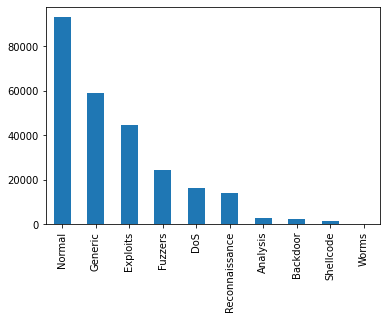

In [57]:
print(total['attack_cat'].value_counts())
total['attack_cat'].value_counts().plot(kind='bar')

In [58]:
# ytest_multi = test['attack_cat']
# ytrain_multi = train['attack_cat']

ytest_multi = total['attack_cat']
ytrain_multi = total['attack_cat']